 # Quick links
 ## If you want to skip to a particular result in this notebook, search for the following terms
 * "What search engines were considered?" / "What devices were considered?" / "What query categories were considered?"
 * "What queries were made?"
 * "What Wikipedia links appeared in SERPs?"
 * "How many times does each Wikipedia link appear for each device and search engine?"
 * "How often did Wikipedia links appear in SERPs?"
 * "How often did Wikipedia links appear in certain locations of SERPs?" (e.g. above-the-fold, in the right-hand column, etc.

 For the code that calculate incidence rates, see analyze_links.py

 # Current data format
 Currently, the node.js scraping code (see collect.js)
 saves 3 result files per SERP scraped:
 * a .json file with
 device object used by puppeteer ("device"), date collection started ("dateStr"),
 date of collection ("dataAtSave"), user-specified query category (queryCat),
 file queries came from ("queryFile"), device name ("deviceName"),
 url accessed ("link"), the search engine or website ("platform"),
 the query made ("target"), and finally, a huge array of link elements ("linkElements")
 * a .png file that is a full screenshot of the SERP
 * a .mhtml snapshot of the website that can be opened in a web browser (this is experimental, apparently)

 Files are named by datetime of script start to avoid accidental overwrite.

 This script (analysis.py) includes code which stitches together a visual representation of
 links and their coordinates (obtained using getBoundingClientRect) alongside screenshots
 so search can perform visual validation -- compare the link representation (easy to do quant analyses)
 with the png representation and make sure they match up!

 # Looking at the data
 ## For a very quick glance, look at all the files in `quick_examples`
 ## Alternatively, can look through the entire `server_output` folder

In [1]:
# defaults
import json
import glob
from pprint import pprint
from collections import defaultdict
from urllib.parse import unquote
import os

# scipy
import pandas as pd
import numpy as np

# plotting / images
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from PIL import Image

# helpers for this project
from helpers import (
    infinite_defaultdict, recurse_print_infinitedict, extract,
    is_mobile,
)
from constants import CONSTANTS


 The heavy lifting of analysis is in "analyze_links.py"
 `analyze_links_df` function takes a dataframe of links
 and calculates the width, height, and normalized coordinates of each link element.
 It extracts the domain from each link (using urlparse(link).netloc, see helpers.py).
 Finally, it calculates a variety of incidence rates: how often are various
 domains appearing in the full page, above-the-fold, in the right column, etc.
 Above-the-fold, right-hand, etc. are calculated using the constants defined above
 such as common viewport heights for desktop and mobile devices.

In [2]:
from analyze_links import analyze_links_df


In [3]:
# Which experiments should we load?
device_names = [
    'Chrome on Windows',
    'iPhone X',
]


search_engines = [
    'google',
    'bing',
    'duckduckgo',
    # 'yahoo' not yet tested, but probably works decently well.
]
query_sets = [
    #'top',
    #'med',
    #'trend',
    'covid19',
]
configs = []
for device_name in device_names:
    for search_engine in search_engines:
        for query_cat in query_sets:
            configs.append({
                'device_name': device_name,
                'search_engine': search_engine,
                'query_cat': query_cat,
            })
    


 Below: load all the files from specified directory
 and put then load them into the "full_df" dataframe

In [4]:
rows = []
outdir = 'server_output' # where are the files
for file in glob.glob(f'{outdir}/**/*.json', recursive=True):
    with open(file, 'r', encoding='utf8') as f:
        d = json.load(f)
    d['fileName'] = file
    rows.append(d)
full_df = pd.DataFrame(rows)
full_df.head(3)


,dateAtSave,dateStr,device,deviceName,fileName,link,linkElements,platform,queryCat,queryFile,target
0,Thu Mar 12 2020 23:45:48 GMT-0500 (Central Day...,Thu Mar 12 2020 23:13:36 GMT-0500 (Central Day...,"{'name': 'Chrome on Windows', 'userAgent': 'Mo...",Chrome on Windows,server_output/Chrome on Windows/https---www.du...,https://www.duckduckgo.com/?q=Social distancing,"[{'top': -85, 'left': 3.5, 'bottom': -41, 'rig...",duckduckgo,covid19,covid19_0,Social distancing
1,Thu Mar 12 2020 23:44:44 GMT-0500 (Central Day...,Thu Mar 12 2020 23:13:39 GMT-0500 (Central Day...,"{'name': 'Chrome on Windows', 'userAgent': 'Mo...",Chrome on Windows,server_output/Chrome on Windows/https---www.go...,https://www.google.com/search?q=Coronavirus sy...,"[{'top': 64, 'left': 11, 'bottom': 108, 'right...",google,covid19,covid19_0,Coronavirus symptoms
2,Thu Mar 12 2020 23:43:15 GMT-0500 (Central Day...,Thu Mar 12 2020 23:13:34 GMT-0500 (Central Day...,"{'name': 'Chrome on Windows', 'userAgent': 'Mo...",Chrome on Windows,server_output/Chrome on Windows/https---www.bi...,https://www.bing.com/search?q=Hand Sanitizer,"[{'top': 24, 'left': 0, 'bottom': 64, 'right':...",bing,covid19,covid19_0,Hand Sanitizer


In [5]:
# ## "What search engines were considered?" / "What devices were considered?" / "What query categories were considered?"
print('Search engines and how many SERPs per search engine:')
print(full_df.platform.value_counts(), '\n')
print('Device names and how many SERPs per device:')
print(full_df.deviceName.value_counts(), '\n')
print('Query categories and how many SERPs per category:')
print(full_df.queryCat.value_counts(), '\n')



Search engines and how many SERPs per search engine:
bing          38
google        38
duckduckgo    38
Name: platform, dtype: int64 

Device names and how many SERPs per device:
Chrome on Windows    57
iPhone X             57
Name: deviceName, dtype: int64 

Query categories and how many SERPs per category:
covid19    114
Name: queryCat, dtype: int64 



In [6]:
# ## "What queries were made?"
print('Queries made and how many SERPs per query:')
print(full_df.target.value_counts().sort_index())


Queries made and how many SERPs per query:
Coronavirus symptoms                            6
Face mask                                       6
Hand Sanitizer                                  6
Hand Washing                                    6
How did the coronavirus get started?            6
How is coronavirus spread?                      6
How many people have died from coronavirus?     6
How to prepare for the coronavirus              6
Social distancing                               6
What is the coronavirus?                        6
What to do if you think you have coronavirus    6
What to do to prepare for coronaivrus           6
What to do to prevent coronavirus               6
What to know about coronavirus                  6
What to stock up on for coronavirus             6
coronavirus                                     6
coronavirus covid19                             6
covid                                           6
covid19                                         6
Name: t

In [7]:
# we will have one dataframe full of links for each combination of device_name / search_engine / query_cat
# in each df, each row corresponds to a single <a> link element
dfs = infinite_defaultdict()
# this three-key dict will be use the following sequence of keys: device_name, search_engine, query_cat

for config in configs:
    device_name = config['device_name']
    search_engine = config['search_engine']
    query_cat = config['query_cat']
    sub = full_df[
        (full_df.deviceName == device_name) &
        (full_df.platform == search_engine) & 
        (full_df.queryCat == query_cat) 
    ]
    links_rows = []
    for i, row in sub.iterrows():
        linkElements = row.linkElements
        for x in linkElements:
            x['target'] = row.target
            x['device_name'] = device_name
            x['search_engine'] = search_engine
            x['query_cat'] = query_cat
            x['file_name'] = row.fileName
        links_rows += linkElements
    links_df = pd.DataFrame(links_rows)

    dfs[device_name][search_engine][query_cat] = analyze_links_df(
        pd.DataFrame(links_df), is_mobile(device_name)
    )


 ## Let's see which links are most common

In [8]:
concat_all_domains = []
for config in configs:
    device_name = config['device_name']
    search_engine = config['search_engine']
    query_cat = config['query_cat']
    concat_all_domains.append(
        dfs[device_name][search_engine][query_cat][['domain']]
    )
print('Top 20 domains in all SERPs collected:')
pd.concat(concat_all_domains)['domain'].value_counts()[:20]


Top 20 domains in all SERPs collected:


duckduckgo.com                    1976
www.google.com                    1814
www.bing.com                      1751
                                  1400
www.cdc.gov                        672
www.who.int                        273
spreadprivacy.com                  203
support.google.com                 178
en.wikipedia.org                   166
webcache.googleusercontent.com     149
www.webmd.com                      142
go.microsoft.com                   111
www.msn.com                         95
www.nytimes.com                     89
donttrack.us                        76
policies.google.com                 76
www.medicalnewstoday.com            60
accounts.google.com                 57
www.usatoday.com                    56
www.walmart.com                     55
Name: domain, dtype: int64

 ## What Wikipedia links appeared in SERPs?

In [9]:
print('What are the Wikipedia links showing up on desktop?')
concat_wp_links = []
for config in configs:
    device_name = config['device_name']
    search_engine = config['search_engine']
    query_cat = config['query_cat']
    tmp = dfs[device_name][search_engine][query_cat]
    tmp = tmp[tmp.wikipedia_appears]
    tmp['norm_href'] = tmp.href.apply(
        lambda x: unquote(x.replace('http://', '').replace('https://', '').replace('.m.', '.'))
    )
    concat_wp_links.append(
        tmp
    )
concatted_wp_links = pd.concat(concat_wp_links)
concatted_wp_links['norm_href'].value_counts()


What are the Wikipedia links showing up on desktop?


en.wikipedia.org/wiki/2019–20_coronavirus_outbreak          36
en.wikipedia.org/wiki/Hand_washing                          25
en.wikipedia.org/wiki/Coronavirus                           21
en.wikipedia.org/wiki/Coronavirus_disease_2019              15
en.wikipedia.org/wiki/Social_distancing                     12
en.wikipedia.org/wiki/Social_distance                        9
en.wikipedia.org/wiki/Covid-19                               7
en.wikipedia.org/wiki/Hand_sanitizer                         7
en.wikipedia.org/wiki/2019–20_Wuhan_coronavirus_outbreak     6
en.wikipedia.org/wiki/2019_novel_coronavirus                 5
en.wikipedia.org/wiki/Surgical_mask                          2
en.wikipedia.org/wiki/Covid                                  1
Name: norm_href, dtype: int64

In [10]:
# How many times does each Wikipedia link appear for each device and search engine?
print('How many times does each Wikipedia link appear for each device and search engine?')
pd.crosstab(concatted_wp_links.norm_href, [concatted_wp_links.device_name, concatted_wp_links.search_engine])



How many times does each Wikipedia link appear for each device and search engine?


device_name                                        Chrome on Windows  \
search_engine                                                   bing   
norm_href                                                              
en.wikipedia.org/wiki/2019_novel_coronavirus                       3   
en.wikipedia.org/wiki/2019–20_Wuhan_coronavirus...                 2   
en.wikipedia.org/wiki/2019–20_coronavirus_outbreak                22   
en.wikipedia.org/wiki/Coronavirus                                  5   
en.wikipedia.org/wiki/Coronavirus_disease_2019                     4   
en.wikipedia.org/wiki/Covid                                        0   
en.wikipedia.org/wiki/Covid-19                                     2   
en.wikipedia.org/wiki/Hand_sanitizer                               3   
en.wikipedia.org/wiki/Hand_washing                                 5   
en.wikipedia.org/wiki/Social_distance                              5   
en.wikipedia.org/wiki/Social_distancing                            2   
en.wikipedia.org/wiki/Surgical_mask                                0   

device_name                                                          iPhone X  \
search_engine                                      duckduckgo google     bing   
norm_href                                                                       
en.wikipedia.org/wiki/2019_novel_coronavirus                0      0        2   
en.wikipedia.org/wiki/2019–20_Wuhan_coronavirus...          2      0        0   
en.wikipedia.org/wiki/2019–20_coronavirus_outbreak          0      0       14   
en.wikipedia.org/wiki/Coronavirus                          10      0        0   
en.wikipedia.org/wiki/Coronavirus_disease_2019              7      0        0   
en.wikipedia.org/wiki/Covid                                 1      0        0   
en.wikipedia.org/wiki/Covid-19                              2      0        1   
en.wikipedia.org/wiki/Hand_sanitizer                        1      0        3   
en.wikipedia.org/wiki/Hand_washing                          3      1        7   
en.wikipedia.org/wiki/Social_distance                       2      0        0   
en.wikipedia.org/wiki/Social_distancing                     4      1        0   
en.wikipedia.org/wiki/Surgical_mask                         2      0        0   

device_name                                                           
search_engine                                      duckduckgo google  
norm_href                                                             
en.wikipedia.org/wiki/2019_novel_coronavirus                0      0  
en.wikipedia.org/wiki/2019–20_Wuhan_coronavirus...          2      0  
en.wikipedia.org/wiki/2019–20_coronavirus_outbreak          0      0  
en.wikipedia.org/wiki/Coronavirus                           6      0  
en.wikipedia.org/wiki/Coronavirus_disease_2019              4      0  
en.wikipedia.org/wiki/Covid                                 0      0  
en.wikipedia.org/wiki/Covid-19                              2      0  
en.wikipedia.org/wiki/Hand_sanitizer                        0      0  
en.wikipedia.org/wiki/Hand_washing                          2      7  
en.wikipedia.org/wiki/Social_distance                       2      0  
en.wikipedia.org/wiki/Social_distancing                     4      1  
en.wikipedia.org/wiki/Surgical_mask                         0      0

In [11]:
# to stitch together image files:
# source: https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python


 the below code creates visualization of our scraped links
 critically, this means we can compare our links (used for quant analysis)
 with actual screenshots of SERPs or actual SERPs.
 To facilitate even easier visual validation, the below code takes a sample of SERPS
 and stitches the coordinate visualization and SERP screenshot together.
 This is pretty slow, so there's a DO_COORDS flag to turn it off.

In [12]:
# create the coordinate visualization
DO_COORDS = False
if DO_COORDS:
    for config in configs:
        device_name = config['device_name']
        search_engine = config['search_engine']
        query_cat = config['query_cat']

        df = dfs[device_name][search_engine][query_cat]
        if type(df) == defaultdict:
            continue
        right_max = df['right'].max()
        bot_max = df['bottom'].max()
        ratio = bot_max / right_max
        k = f'{device_name}_{search_engine}_{query_cat}'
        print(k)

        available_targets = list(full_df[
            (full_df.deviceName == device_name) & (full_df.platform == search_engine) & (full_df.queryCat == query_cat)
        ].target)

        np.random.seed(0)
        chosen_ones = np.random.choice(available_targets, 5, replace=False)
        with open(f'reports/samples/{k}.txt', 'w', encoding='utf8') as f:
            f.write('\n'.join(chosen_ones))
        for target in available_targets + [None]:
            if target:
                subdf = df[df['target'] == target]
            else:
                subdf = df
            file_name = subdf.file_name.iloc[0]
            if target:
                assert len(set(subdf.file_name)) == 1
            fig, ax = plt.subplots(1, 1, figsize=(CONSTANTS['figure_width'], CONSTANTS['figure_width'] * ratio))
            plt.gca().invert_yaxis()
            add_last = []
            for i_row, row in subdf.iterrows():
                if row.width == 0 or row.height == 0:
                    continue
                x = row['left']
                y = row['bottom']
                width = row['width']
                height = row['height']
                domain = row['domain']

                if row['wikipedia_appears']:
                    # add it to the plot last so it is on top
                    add_last.append([domain, (x,y,), width, height])
                    
                else:
                    if row['platform_ugc']:
                        color = 'b'
                    # color internal search engine links as lightgray
                    if 'google' in domain or 'bing' in domain or 'duckduckgo' in domain:
                        color = 'lightgray'
                    else:
                        color = 'grey'
                    plt.annotate(domain, (x, y), color=color)
                    # Add the patch to the Axes
                    rect = matplotlib.patches.Rectangle((x,y),width,height,linewidth=1,edgecolor=color,facecolor='none')
                    ax.add_patch(rect)
            for domain, coords, width, height in add_last:
                plt.annotate(domain, coords, color='g')
                rect = matplotlib.patches.Rectangle(coords,width,height,linewidth=2,edgecolor=color,facecolor='none')
                ax.add_patch(rect)

            # kp line = lefthand width border.
            kp_line = CONSTANTS['lefthand_width']
            if is_mobile(device_name):
                scroll_line = CONSTANTS['mobile_lines']['noscroll_mg']
            else:
                scroll_line = CONSTANTS['desktop_lines']['noscroll_mg']
            plt.axvline(kp_line, color='r', linestyle='-')

            # show the right edge of the viewport
            plt.axvline(CONSTANTS['viewport_width'], color='k', linestyle='-')
            # show the page-fold
            plt.axhline(scroll_line, color='k', linestyle='-')

            overlay_file_name = f'{file_name}_overlay.png'
            plt.savefig(overlay_file_name)
            #plt.savefig(f'reports/overlays/{k}_{target}_{file_name}.png')

            plt.close()
            if target in chosen_ones:
                screenshot_path = file_name.replace('.json', '.png')
                # the overlay will be smaller
                #TODO
                try:
                    screenshot_img = Image.open(screenshot_path)
                    big_w, big_h = screenshot_img.size
                    overlay_img = Image.open(overlay_file_name)
                    small_w, small_h = overlay_img.size
                except FileNotFoundError: 
                    continue

                h_percent = (big_h/float(small_h))
                new_w = int((float(small_w) * float(h_percent)))
                resized_overlay = overlay_img.resize((new_w,big_h), Image.ANTIALIAS)

                total_width = new_w + big_w

                new_im = Image.new('RGB', (total_width, big_h))

                x_offset = 0
                for im in (screenshot_img, resized_overlay):
                    new_im.paste(im, (x_offset,0))
                    x_offset += im.size[0]
                new_im.save(f'reports/samples/concat_{k}_{target}.png')



In [13]:
# toss results in here for easy dataframe creation
row_dicts = [] # each row is one config: device_name / search_engine / query_cat (/geography?)
for config in configs:
    device_name = config['device_name']
    search_engine = config['search_engine']
    query_cat = config['query_cat']

    print(device_name, search_engine, query_cat)
    df = dfs[device_name][search_engine][query_cat]
    if type(df) == defaultdict:
        continue

    inc_rate = df.groupby('target').wikipedia_appears.agg(any).mean()
    rh_inc_rate = df.groupby('target').wikipedia_appears_rh.agg(any).mean()
    lh_inc_rate = df.groupby('target').wikipedia_appears_lh.agg(any).mean()

    if is_mobile(device_name):
        d = CONSTANTS['mobile_lines']
    else:
        d = CONSTANTS['desktop_lines']
    matches = set(df[df.wikipedia_appears == True]['target'])

    row_dict = {
        'query_cat': query_cat,
        'search_engine': search_engine,
        'device_name': device_name,
        'inc_rate': inc_rate,
        'rh_inc_rate': rh_inc_rate,
        'lh_inc_rate': lh_inc_rate,
        'matches': matches
    }
    for name in d.keys():
        row_dict[f'{name}_inc_rate'] = df.groupby('target')[f'wikipedia_appears_{name}'].agg(any).mean()
        row_dict[f'lh_{name}_inc_rate'] = df.groupby('target')[f'wikipedia_appears_lh_{name}'].agg(any).mean()
    for domain in [
        'twitter', 'youtube',
        'facebook',
    ]:
        row_dict[f'{domain}_inc_rate'] = df.groupby('target')[f'{domain}_appears'].agg(any).mean() 


    row_dicts.append(row_dict)

Chrome on Windows google covid19
Chrome on Windows bing covid19
Chrome on Windows duckduckgo covid19
iPhone X google covid19
iPhone X bing covid19
iPhone X duckduckgo covid19


In [14]:
results_df = pd.DataFrame(row_dicts)
results_df.head(3)


,device_name,facebook_inc_rate,inc_rate,lh_inc_rate,lh_noscroll_lb_inc_rate,lh_noscroll_mg_inc_rate,lh_noscroll_ub_inc_rate,matches,noscroll_lb_inc_rate,noscroll_mg_inc_rate,noscroll_ub_inc_rate,query_cat,rh_inc_rate,search_engine,twitter_inc_rate,youtube_inc_rate
0,Chrome on Windows,0.0,0.105263,0.105263,0.000000,0.000000,0.000000,"{Social distancing, Hand Washing}",0.000000,0.000000,0.000000,covid19,0.000000,google,0.052632,0.105263
1,Chrome on Windows,0.0,0.894737,0.736842,0.210526,0.315789,0.315789,"{What to do to prevent coronavirus, coronaviru...",0.421053,0.526316,0.526316,covid19,0.736842,bing,0.000000,0.105263
2,Chrome on Windows,0.0,0.526316,0.421053,0.315789,0.368421,0.368421,"{covid19, coronavirus, Hand Washing, Face mask...",0.473684,0.473684,0.473684,covid19,0.421053,duckduckgo,0.000000,0.105263


 ## How often did Wikipedia links appear in SERPs? (tabular)

In [15]:

results_df[
    ['device_name', 'search_engine', 'inc_rate', 'matches']
]



,device_name,search_engine,inc_rate,matches
0,Chrome on Windows,google,0.105263,"{Social distancing, Hand Washing}"
1,Chrome on Windows,bing,0.894737,"{What to do to prevent coronavirus, coronaviru..."
2,Chrome on Windows,duckduckgo,0.526316,"{covid19, coronavirus, Hand Washing, Face mask..."
3,iPhone X,google,0.105263,"{Social distancing, Hand Washing}"
4,iPhone X,bing,0.684211,"{What to do to prevent coronavirus, coronaviru..."
5,iPhone X,duckduckgo,0.368421,"{covid19, coronavirus, Hand Washing, Social di..."


In [16]:
FP = 'Full-page incidence'
RH = 'Right-hand incidence'
LH = 'Left-hand incidence'
AF_MG = 'Above-the-fold incidence'
AF_pretty = 'Above-the-fold incidence (lower bound - upper bound)'

LH_AF_pretty = 'Left-hand above-the-fold incidence (lower bound - upper bound)'
LH_AF_LB = 'Left-hand above-the-fold incidence (lower bound)' 
LH_AF_MG = 'Left-hand above-the-fold incidence'
LH_AF_UB = 'Left-hand above-the-fold incidence (upper bound)' 

AF_LB = 'Above-the-fold incidence (lower bound)'
AF_UB = 'Above-the-fold incidence (upper bound)'

cols = [
    'device_name', 'search_engine', 'query_cat', 'inc_rate', 'rh_inc_rate',
    'lh_inc_rate',
]
for name in CONSTANTS['mobile_lines'].keys():
    cols += [f'{name}_inc_rate', f'lh_{name}_inc_rate']
print(cols)

renamed = results_df[cols]
renamed.rename(columns={
    'device_name': 'Device', 'search_engine': 'Search Engine',
    'query_cat': 'Query Category', 'inc_rate': FP,
    'rh_inc_rate': RH,
    'lh_inc_rate': LH,
    'lh_noscroll_lb_inc_rate': LH_AF_LB,
    'lh_noscroll_mg_inc_rate': LH_AF_MG,
    'lh_noscroll_ub_inc_rate': LH_AF_UB,
    'noscroll_lb_inc_rate': AF_LB,
    'noscroll_mg_inc_rate': AF_MG,
    'noscroll_ub_inc_rate': AF_UB,
    'youtube_inc_rate': 'Youtube incidence rate',
    'twitter_inc_rate': 'Twitter incidence rate',
}, inplace=True)

def pretty_bounds(row):
    mg = row[AF_MG]
    lb = row[AF_LB]
    ub = row[AF_UB]
    return f'{mg:.2f} ({lb:.2f} - {ub:.2f})'

def pretty_bounds_lh(row):
    mg = row[LH_AF_MG]
    lb = row[LH_AF_LB]
    ub = row[LH_AF_UB]
    return f'{mg:.2f} ({lb:.2f} - {ub:.2f})'

renamed[AF_pretty] = renamed.apply(pretty_bounds, axis=1)
renamed[LH_AF_pretty] = renamed.apply(pretty_bounds_lh, axis=1)

renamed.replace(to_replace={
    'top': 'common',
    'med': 'medical',
    'trend': 'trending',
    'covid19': 'COVID-19'
}, inplace=True)
renamed

renamed[[
    'Device', 'Search Engine', 'Query Category',
    FP, RH, LH, AF_pretty, LH_AF_pretty
]].to_csv('reports/main.csv', float_format="%.2f", index=False)


['device_name', 'search_engine', 'query_cat', 'inc_rate', 'rh_inc_rate', 'lh_inc_rate', 'noscroll_lb_inc_rate', 'lh_noscroll_lb_inc_rate', 'noscroll_mg_inc_rate', 'lh_noscroll_mg_inc_rate', 'noscroll_ub_inc_rate', 'lh_noscroll_ub_inc_rate']


In [17]:
renamed[
    renamed.Device == 'desktop'
][[
    'Search Engine', 'Query Category',
    FP,  LH, RH, AF_pretty, LH_AF_pretty
]].to_csv('reports/desktop.csv', float_format="%.2f", index=False)
renamed[
    renamed.Device == 'mobile'
][[
    'Search Engine', 'Query Category',
    FP, AF_pretty
]].to_csv('reports/mobile.csv', float_format="%.2f", index=False)


In [18]:
renamed.head(3)


,Device,Search Engine,Query Category,Full-page incidence,Right-hand incidence,Left-hand incidence,Above-the-fold incidence (lower bound),Left-hand above-the-fold incidence (lower bound),Above-the-fold incidence,Left-hand above-the-fold incidence,Above-the-fold incidence (upper bound),Left-hand above-the-fold incidence (upper bound),Above-the-fold incidence (lower bound - upper bound),Left-hand above-the-fold incidence (lower bound - upper bound)
0,Chrome on Windows,google,COVID-19,0.105263,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00 (0.00 - 0.00),0.00 (0.00 - 0.00)
1,Chrome on Windows,bing,COVID-19,0.894737,0.736842,0.736842,0.421053,0.210526,0.526316,0.315789,0.526316,0.315789,0.53 (0.42 - 0.53),0.32 (0.21 - 0.32)
2,Chrome on Windows,duckduckgo,COVID-19,0.526316,0.421053,0.421053,0.473684,0.315789,0.473684,0.368421,0.473684,0.368421,0.47 (0.47 - 0.47),0.37 (0.32 - 0.37)


In [19]:
baseline_df = results_df[['device_name', 'search_engine', 'query_cat', 'twitter_inc_rate', 'youtube_inc_rate', 'facebook_inc_rate']]
baseline_df.rename(columns={
    'device_name': 'Device', 'search_engine': 'Search Engine',
    'query_cat': 'Query Category'
}, inplace=True)
baseline_df.to_csv('reports/other_domains.csv', float_format="%.2f", index=False)


In [20]:
melted = renamed.melt(id_vars=['Device', 'Search Engine', 'Query Category'])

In [21]:
melted.head(3)


,Device,Search Engine,Query Category,variable,value
0,Chrome on Windows,google,COVID-19,Full-page incidence,0.105263
1,Chrome on Windows,bing,COVID-19,Full-page incidence,0.894737
2,Chrome on Windows,duckduckgo,COVID-19,Full-page incidence,0.526316


 ## How often did Wikipedia links appear in SERPs? (visual)

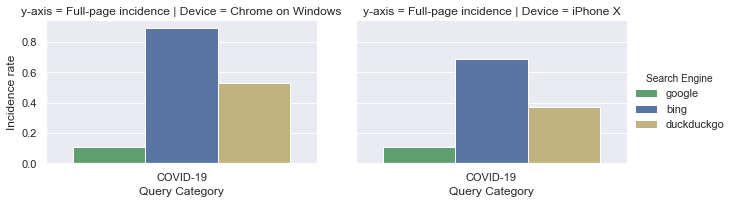

In [22]:
melted.rename(columns={
    'variable': 'y-axis',
    'value': 'Incidence rate',
}, inplace=True)
sns.set()
g = sns.catplot(
    x="Query Category", y='Incidence rate',
    hue="Search Engine", col="Device", row='y-axis',
    palette=['g', 'b', 'y'],
    #order=['COVID-19'],
    #row_order=[FP, AF, RH],
    data=melted[melted['y-axis'] == FP], kind="bar",
    height=3, aspect=1.5, ci=None,
    sharex=False,
)
plt.savefig('reports/FP_catplot.png', dpi=300)



 ## How often did Wikipedia links appear in certain locations of SERPs?

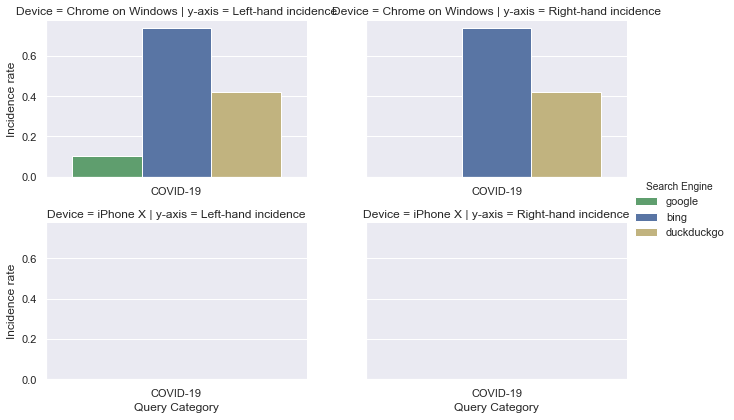

In [23]:
# lh vs rh
g = sns.catplot(
    x="Query Category", y='Incidence rate',
    hue="Search Engine", col='y-axis', row='Device',
    col_order=[LH, RH],
    palette=['g', 'b', 'y'],
    #order=['common', 'trending', 'medical'],
    data=melted[
        ((melted['y-axis'] == LH) | (melted['y-axis'] == RH))
    ],
    kind="bar",
    height=3, aspect=1.5, ci=None,
    sharex=False,
)
plt.savefig('reports/LHRH_catplot.png', dpi=300)

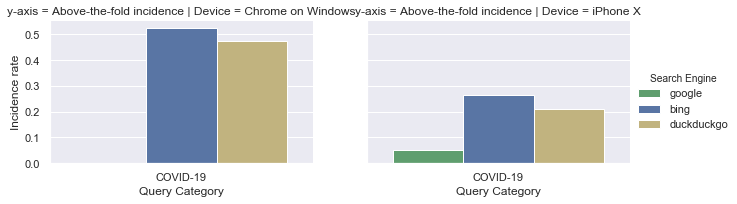

In [24]:
g = sns.catplot(
    x="Query Category", y='Incidence rate',
    hue="Search Engine", col="Device", row='y-axis',
    palette=['g', 'b', 'y'],
    #order=['common', 'trending', 'medical'],
    #row_order=[FP, AF, RH],
    data=melted[melted['y-axis'] == AF_MG], kind="bar",
    height=3, aspect=1.5, ci=None,
    sharex=False,
)
plt.savefig('reports/AF_catplot.png', dpi=300)


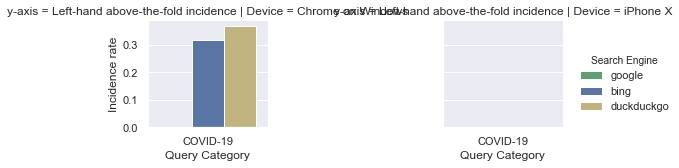

In [25]:
g = sns.catplot(
    x="Query Category", y='Incidence rate',
    hue="Search Engine", col="Device", row='y-axis',
    palette=['g', 'b', 'y'],
    #order=['common', 'trending', 'medical'],
    data=melted[melted['y-axis'] == LH_AF_MG], kind="bar",
    height=2.5, aspect=1.5, ci=None,
    sharex=False,
)
plt.savefig('reports/LH_AF_catplot.png', dpi=300)



In [26]:
# max difference between search engines
results_df.groupby(['device_name', 'query_cat']).agg(lambda x: max(x) - min(x))['inc_rate']


device_name        query_cat
Chrome on Windows  covid19      0.789474
iPhone X           covid19      0.578947
Name: inc_rate, dtype: float64

In [27]:
# max difference between devices
results_df.groupby(['search_engine', 'query_cat']).agg(lambda x: max(x) - min(x))['inc_rate']


search_engine  query_cat
bing           covid19      0.210526
duckduckgo     covid19      0.157895
google         covid19      0.000000
Name: inc_rate, dtype: float64

In [28]:
# diff between FP and AF
melted[
    (melted['y-axis'] == FP) | (melted['y-axis'] == AF_MG)
].groupby(['Device', 'Query Category', 'Search Engine']).agg(lambda x: max(x) - min(x))


Incidence rate
Device            Query Category Search Engine                
Chrome on Windows COVID-19       bing                 0.368421
                                 duckduckgo           0.052632
                                 google               0.105263
iPhone X          COVID-19       bing                 0.421053
                                 duckduckgo           0.157895
                                 google               0.052632

In [29]:
# what's in the first but not in the second

se_minus_se = {}
se_to_matches = {}
sub = results_df[(results_df.device_name == 'Chrome on Windows') & (results_df.query_cat == 'covid19')]
for i, row in sub.iterrows():
    se_to_matches[row.search_engine] = set(row.matches)
se_to_matches
for k1, v1 in se_to_matches.items():
    for k2, v2 in se_to_matches.items():
        if k1 == k2:
            continue
        se_minus_se[f'{k1}_{k2}'] = v1 - v2


In [30]:
# what's in the first but not in the second

pprint(se_minus_se)



{'bing_duckduckgo': {'Coronavirus symptoms',
                     'How is coronavirus spread?',
                     'How many people have died from coronavirus?',
                     'How to prepare for the coronavirus',
                     'What to do if you think you have coronavirus',
                     'What to do to prevent coronavirus',
                     'What to know about coronavirus',
                     'What to stock up on for coronavirus'},
 'bing_google': {'Coronavirus symptoms',
                 'Hand Sanitizer ',
                 'How did the coronavirus get started?',
                 'How is coronavirus spread?',
                 'How many people have died from coronavirus?',
                 'How to prepare for the coronavirus',
                 'What is the coronavirus?',
                 'What to do if you think you have coronavirus',
                 'What to do to prevent coronavirus',
                 'What to know about coronavirus',
                 'W